# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import os
import scipy
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\\downloadfolder\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 348260/348260 [02:18<00:00, 2514.94it/s]


In [23]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

In [25]:
final["preprocessed_reviews"]=preprocessed_reviews
final=final.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator"],axis=1)
final_last=final.drop(["HelpfulnessDenominator","Time","Summary","Text"],axis=1)
final_last.head()

,Score,preprocessed_reviews
138702,1,book purchased birthday gift year old boy sque...
138707,1,daughter loves really rosie books introduced r...
138708,0,one best children books ever written mini vers...
138692,1,title chicken soup riceauthor maurice sendakre...
138689,1,fun way children learn months year learn poems...


In [26]:
X=final_last["preprocessed_reviews"]
Y=final_last["Score"]

In [27]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X[:100000],Y[:100000],test_size=0.33,random_state=1)

## Logistic Regression on BOW

In [28]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
X_train_bow_bigram = count_vect.fit_transform(X_train)
X_test_bow_bigram = count_vect.transform(X_test)
print("After vectorizations")
print(X_train_bow_bigram.shape, y_train.shape)
print(X_test_bow_bigram.shape, y_test.shape)
print("="*100)
print("the type of count vectorizer ",type(X_train_bow_bigram))
print("the number of unique words in train", X_train_bow_bigram.get_shape()[1])

After vectorizations
(67000, 500) (67000,)
(33000, 500) (33000,)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in train 500


### Applying Logistic Regression with L2 regularization on BOW

#### Applying grid search to do hyperparameter tuning

In [42]:

log_clf = LogisticRegression(n_jobs=-1,penalty='l2',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf, parameters, cv=10, scoring='roc_auc')
clf.fit(X_train_bow_bigram, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

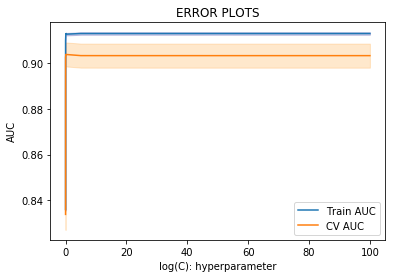

In [43]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [44]:
print("best estimator is :\n",clf.best_estimator_)

best estimator is :
 LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [45]:
#lets take C=0.05
#and apply it on test data.

In [46]:
log_reg=LogisticRegression(C=0.05,penalty='l2',class_weight='balanced')

log_reg.fit(X_train_bow_bigram,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(X_train_bow_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_bow_bigram)[:,1])

In [47]:

#coefficients = pd.DataFrame({"Feature":count_vect.get_feature_names(),"Coefficients":np.transpose(log_reg.coef_[0])})

In [48]:
#coefficients.sort_values('Coefficients',ascending=False)

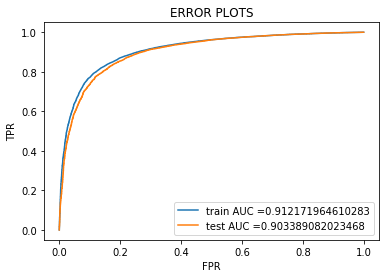

Train confusion matrix
[[ 8434  1453]
 [ 9884 47229]]
Test confusion matrix
[[ 4056   833]
 [ 4769 23342]]


In [49]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg.predict(X_train_bow_bigram)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg.predict(X_test_bow_bigram)))

#### Feature importance

In [50]:
#lets find out top 10 positive features and top 10 negative features.

coefficients = pd.DataFrame({"Feature":count_vect.get_feature_names(),"Coefficients":np.transpose(log_reg.coef_[0])})

In [51]:
coefficients=coefficients.sort_values('Coefficients',ascending=False)

In [52]:
print("Top 10 positive features are:\n")
coefficients[:10]

Top 10 positive features are:



,Coefficients,Feature
260,1.484185,loves
111,1.452842,delicious
336,1.376686,pleased
24,1.309166,awesome
144,1.294458,excellent
14,1.212249,amazing
499,1.175422,yummy
487,1.149863,wonderful
36,1.136808,best
195,1.126189,great


In [53]:
print("Top 10 negative features are:\n")
coefficients[-10:]

Top 10 negative features are:



,Coefficients,Feature
312,-0.598584,opened
363,-0.598703,received
473,-0.631493,wanted
318,-0.638419,original
269,-0.680569,maybe
27,-0.683058,bad
23,-0.786445,away
450,-0.788959,thought
278,-1.215600,money
116,-1.473046,disappointed


## Perturbation Testing

In [54]:
#weights W after fitting our model with the Train data(X_train_bow_bigram)
coef_1=log_reg.coef_[0]  #an array

In [55]:
type(X_train_bow_bigram)
X_train_bow_bigram_1=X_train_bow_bigram.toarray()
X_test_bow_bigram_1=X_test_bow_bigram.toarray()

In [56]:
X_train_bow_bigram_1.shape

(67000, 500)

In [57]:
#Adding a noise to the X (X' = X + e) and get the new data set X'
X_train_bow_bigram_1=X_train_bow_bigram_1+0.001
X_test_bow_bigram_1=X_test_bow_bigram_1+0.001

In [58]:
from scipy import sparse
X_train_bow_bigram_1=sparse.csr_matrix(X_train_bow_bigram_1)

In [59]:
type(X_train_bow_bigram_1)

scipy.sparse.csr.csr_matrix

In [60]:
#Fitting the model again on data X' and get the weights W'
log_reg=LogisticRegression(C=0.05,penalty='l2')

log_reg.fit(X_train_bow_bigram_1,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(X_train_bow_bigram_1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_bow_bigram_1)[:,1])

In [61]:
coef_2=log_reg.coef_[0]

In [62]:
#Adding a small eps value(to eliminate the divisible by zero error) to coef_1 and coef_2

coef_1=coef_1 + 0.000001
coef_2=coef_2 + 0.000001

In [63]:
#finding the % change between coef_1 and coef_2
perct_chg_vector=((coef_1-coef_2) / (coef_1))*100

In [64]:
perct_chg_vector.shape

(500,)

In [65]:
#Calculating the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector
for i in np.arange(0,101,1):
    print(i,"th percentile of change vector is",np.percentile(perct_chg_vector,i))

0 th percentile of change vector is -9530.032086000483
1 th percentile of change vector is -1202.544940157826
2 th percentile of change vector is -585.7869139530417
3 th percentile of change vector is -349.3891303778503
4 th percentile of change vector is -241.78166988198927
5 th percentile of change vector is -113.38742027075486
6 th percentile of change vector is -82.63994594460681
7 th percentile of change vector is -76.67932362588351
8 th percentile of change vector is -66.53453149199578
9 th percentile of change vector is -59.14467436304265
10 th percentile of change vector is -46.24918704348923
11 th percentile of change vector is -40.12925461721504
12 th percentile of change vector is -34.250222735286755
13 th percentile of change vector is -30.77852346532901
14 th percentile of change vector is -26.999377471184122
15 th percentile of change vector is -24.316029003187225
16 th percentile of change vector is -21.10141593205362
17 th percentile of change vector is -17.823459877714

In [66]:
#we can see that there is sudden rise in between 0th to 10th percentile and
#in between 90th to 100th percentile

In [67]:
#lets drill down further at which point percentile changing(between 0 and 1) greater than 2.5(threshold)
for i in np.arange(0,1.1,0.1):
    print(i,"th percentile of change vector is",-np.percentile(perct_chg_vector,i) ,)

0.0 th percentile of change vector is 9530.032086000483
0.1 th percentile of change vector is 9251.368917362399
0.2 th percentile of change vector is 8972.705748724315
0.30000000000000004 th percentile of change vector is 7786.439025545633
0.4 th percentile of change vector is 6596.519974179667
0.5 th percentile of change vector is 4258.799745070217
0.6000000000000001 th percentile of change vector is 1911.8043549284932
0.7000000000000001 th percentile of change vector is 1798.9329389297156
0.8 th percentile of change vector is 1713.2516727176642
0.9 th percentile of change vector is 1459.269394115061
1.0 th percentile of change vector is 1202.544940157826


In [68]:
#lets drill down further at which point percentile changing(between 99 and 100) greater than 2.5(threshold)
for i in np.arange(99,100.1,0.1):
    print(i,"th percentile of change vector is",-np.percentile(perct_chg_vector,i))

99.0 th percentile of change vector is -513.4512220035314
99.1 th percentile of change vector is -639.295593726007
99.19999999999999 th percentile of change vector is -764.1872185956942
99.29999999999998 th percentile of change vector is -830.6040053767083
99.39999999999998 th percentile of change vector is -897.2929290023375
99.49999999999997 th percentile of change vector is -986.3424300289378
99.59999999999997 th percentile of change vector is -1078.94716756694
99.69999999999996 th percentile of change vector is -1611.512423406315
99.79999999999995 th percentile of change vector is -2145.381981110051
99.89999999999995 th percentile of change vector is -3003.370552112656
99.99999999999994 th percentile of change vector is -3861.3591231152614


In [69]:
perc_change = [abs(np.percentile(perct_chg_vector,i)) for i in np.arange(0,101,1)] 
perc_change_explained = np.cumsum(perc_change)

Text(0,0.5,'cumulative_variance_explained')

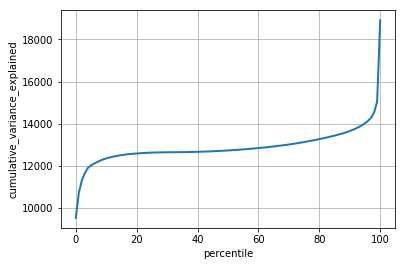

In [70]:
plt.figure(1,figsize=(6,4))
plt.plot(perc_change_explained,linewidth=2)
plt.grid()

plt.axis('tight')

plt.xlabel("percentile")
plt.ylabel("cumulative_variance_explained")

In [71]:
weights_difference = abs(perct_chg_vector)

In [72]:
print("Number of features have weight changes greater than 2.5% are :",weights_difference[np.where(weights_difference>2.5)].size)

Number of features have weight changes greater than 2.5% are : 464


### Applying Logistic Regression with L1 regularization on BOW

#### Applying gridsearch to do hyperparameter tuning

In [73]:
#now applying L1 regularizer on BOW logistic regression.

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(n_jobs=-1,penalty='l1',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf, parameters, cv=10, scoring='roc_auc')
clf.fit(X_train_bow_bigram, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

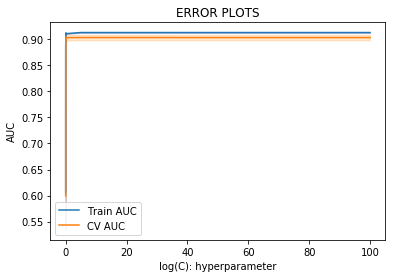

In [74]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [75]:
print("best estimator is :",clf.best_estimator_)

best estimator is : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [76]:
log_reg=LogisticRegression(C=0.1,penalty='l1',class_weight='balanced')

log_reg.fit(X_train_bow_bigram,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(X_train_bow_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_bow_bigram)[:,1])

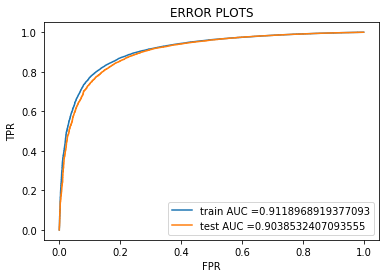

Train confusion matrix
[[ 8447  1440]
 [ 9948 47165]]
Test confusion matrix
[[ 4055   834]
 [ 4805 23306]]


In [77]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg.predict(X_train_bow_bigram)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg.predict(X_test_bow_bigram)))

Heatmap for train confusion matrix


Text(33,0.5,'Actual Class')

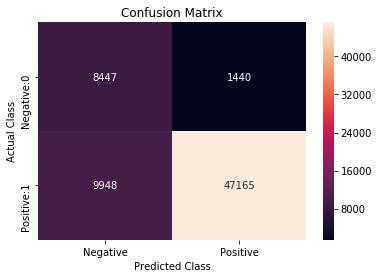

In [78]:
import seaborn as sns
print("Heatmap for train confusion matrix")
confusion_matrix_train_tfidf = confusion_matrix(y_train, log_reg.predict(X_train_bow_bigram))

df_cm=pd.DataFrame(confusion_matrix_train_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap for test confusion matrix


Text(33,0.5,'Actual Class')

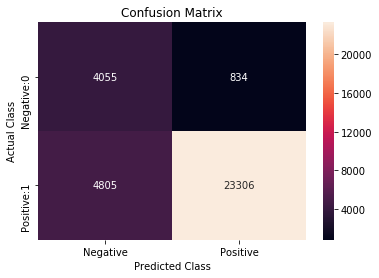

In [79]:

print("Heatmap for test confusion matrix")
confusion_matrix_train_tfidf = confusion_matrix(y_test, log_reg.predict(X_test_bow_bigram))

df_cm=pd.DataFrame(confusion_matrix_train_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

#### Calculating sparsity on weight vector obtained using L1 regularization on BOW

In [80]:
sparse_coef=log_reg.coef_

In [81]:
print("Number of non zero weights after applying L1 regularizer when C=0.1 are :",np.count_nonzero(sparse_coef))

Number of non zero weights after applying L1 regularizer when C=0.1 are : 441


In [82]:
print("sparsity on weight vector obtained using L1 regularization when C=0.1 on BOW:", (500-377)/500*100)

sparsity on weight vector obtained using L1 regularization when C=0.1 on BOW: 24.6


In [83]:
#lets change value of C(hyperparameter) to see impact of C on sparsity of vectors

In [84]:
#1st changing C=1.0
C=1.0

log_reg=LogisticRegression(C=1.0,penalty='l1')

log_reg.fit(X_train_bow_bigram,y_train)

sparse_coef=log_reg.coef_

print("Number of non zero weights after applying L1 regularizer when C=1.0 are :",np.count_nonzero(sparse_coef))

print("sparsity on weight vector obtained using L1 regularization on BOW:", (500-np.count_nonzero(sparse_coef))/500*100)

Number of non zero weights after applying L1 regularizer when C=1.0 are : 493
sparsity on weight vector obtained using L1 regularization on BOW: 1.4000000000000001


In [85]:
#changing C=0.05
C=0.05

log_reg=LogisticRegression(C=0.05,penalty='l1')

log_reg.fit(X_train_bow_bigram,y_train)

sparse_coef=log_reg.coef_

print("Number of non zero weights after applying L1 regularizer when C=0.05 are :",np.count_nonzero(sparse_coef))

print("sparsity on weight vector obtained using L1 regularization on BOW:", (500-np.count_nonzero(sparse_coef))/500*100)

Number of non zero weights after applying L1 regularizer when C=0.05 are : 335
sparsity on weight vector obtained using L1 regularization on BOW: 33.0


In [86]:
#1st changing C=10
log_reg=LogisticRegression(C=10,penalty='l1')

log_reg.fit(X_train_bow_bigram,y_train)

sparse_coef=log_reg.coef_

print("Number of non zero weights after applying L1 regularizer when C=10.0 are :",np.count_nonzero(sparse_coef))

print("sparsity on weight vector obtained using L1 regularization on BOW:", (500-np.count_nonzero(sparse_coef))/500*100)

Number of non zero weights after applying L1 regularizer when C=10.0 are : 500
sparsity on weight vector obtained using L1 regularization on BOW: 0.0


##### Sparsity of weight vectors decreases as we are increasing value of C

## TF-IDF

In [87]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tf_idf=tf_idf_vect.fit_transform(X_train)
X_test_tf_idf = tf_idf_vect.transform(X_test)
print("After vectorizations")
print(X_train_tf_idf.shape, y_train.shape)
print(X_test_tf_idf.shape, y_test.shape)
print("="*100)
print("the type of count vectorizer ",type(X_train_tf_idf))
print("the number of unique words in train", X_train_tf_idf.get_shape()[1])

After vectorizations
(67000, 37866) (67000,)
(33000, 37866) (33000,)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in train 37866


### Applying Logistic Regression with L2 regularization on TFIDF

#### Applying gridsearch to do hyperparameter tuning 

In [88]:
log_clf = LogisticRegression(n_jobs=-1,penalty='l2',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf, parameters, cv=10, scoring='roc_auc')
clf.fit(X_train_tf_idf, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

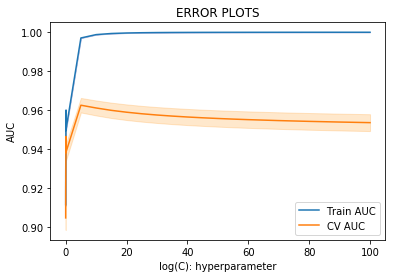

In [89]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [90]:
print("best estimator is :\n",clf.best_estimator_)

best estimator is :
 LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [91]:
log_reg=LogisticRegression(C=5,penalty='l2',class_weight='balanced')

log_reg.fit(X_train_tf_idf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_tf_idf)[:,1])

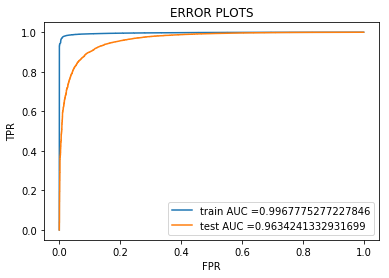

Train confusion matrix
[[ 9822    65]
 [ 1931 55182]]
Test confusion matrix
[[ 4112   777]
 [ 1626 26485]]


In [92]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg.predict(X_train_tf_idf)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg.predict(X_test_tf_idf)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

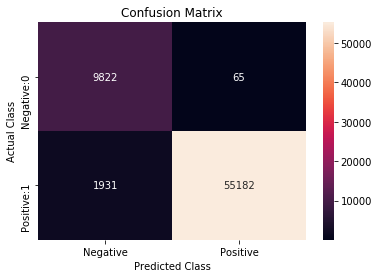

In [93]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_TFIDF = confusion_matrix(y_train, log_reg.predict(X_train_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

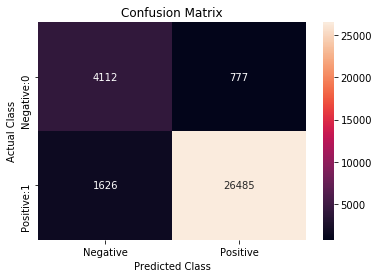

In [94]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_TFIDF = confusion_matrix(y_test, log_reg.predict(X_test_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### Feature Importance on TFIDF

In [95]:
#lets find out top 10 positive features and top 10 negative features.

coefficients = pd.DataFrame({"Feature":tf_idf_vect.get_feature_names(),"Coefficients":np.transpose(log_reg.coef_[0])})

In [96]:
coefficients=coefficients.sort_values('Coefficients',ascending=False)

In [97]:
print("Top 10 positive features are:\n")
coefficients[:10]

Top 10 positive features are:



,Coefficients,Feature
14375,16.965654,great
7928,13.810875,delicious
2685,12.559008,best
19097,12.057211,loves
13766,11.764950,good
22185,10.837792,not disappointed
18812,10.529132,love
24662,10.092517,perfect
10287,9.615839,excellent
1899,9.051281,awesome


In [98]:
print("Top 10 negative features are:\n")
coefficients[-10:]

Top 10 negative features are:



,Coefficients,Feature
8456,-8.920248,disappointment
22005,-9.328993,not
33362,-9.518415,terrible
22297,-9.955640,not good
1910,-10.624935,awful
22552,-10.884238,not recommend
8454,-11.220235,disappointing
22758,-11.884662,not worth
37325,-12.867089,worst
8431,-13.637602,disappointed


### Applying Logistic Regression with L1 regularization on TFIDF

#### Applying gridsearch to do hyperparameter tuning

In [99]:
#Applying L1 regularizer on TFIDF

log_clf = LogisticRegression(n_jobs=-1,penalty='l1',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf, parameters, cv=10, scoring='roc_auc')
clf.fit(X_train_tf_idf, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

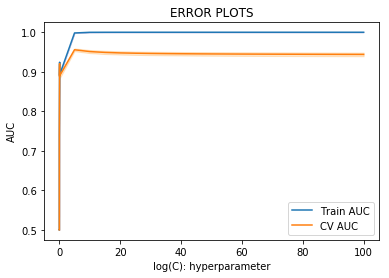

In [100]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [101]:
print("best estimator is :\n",clf.best_estimator_)

best estimator is :
 LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [102]:
log_reg=LogisticRegression(C=5,penalty='l1',class_weight='balanced')

log_reg.fit(X_train_tf_idf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_tf_idf)[:,1])

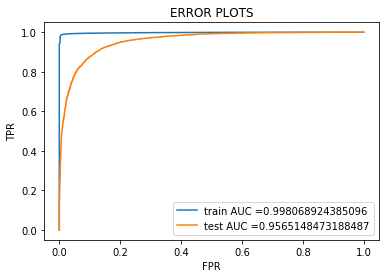

Train confusion matrix
[[ 9858    29]
 [ 1512 55601]]
Test confusion matrix
[[ 3981   908]
 [ 1612 26499]]


In [103]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg.predict(X_train_tf_idf)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg.predict(X_test_tf_idf)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

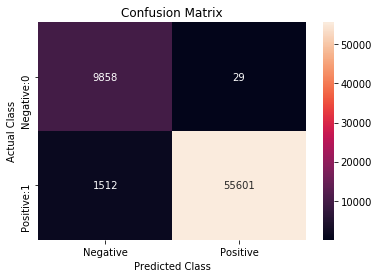

In [104]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_TFIDF = confusion_matrix(y_train, log_reg.predict(X_train_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

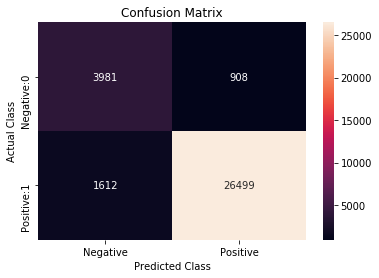

In [105]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_TFIDF = confusion_matrix(y_test, log_reg.predict(X_test_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

##  Avg Word2Vec

### Converting text into vectors using Avg W2V

In [106]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())


In [107]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))

[('fantastic', 0.8460413217544556), ('terrific', 0.8438283801078796), ('good', 0.841871976852417), ('awesome', 0.841789960861206), ('wonderful', 0.829041600227356), ('excellent', 0.8117685317993164), ('perfect', 0.7637959122657776), ('amazing', 0.7529999017715454), ('fabulous', 0.7215555310249329), ('incredible', 0.695601761341095)]
[('nastiest', 0.7941640615463257), ('greatest', 0.7499529123306274), ('disgusting', 0.7321649789810181), ('best', 0.7056533694267273), ('awful', 0.651665449142456), ('horrible', 0.6460586786270142), ('tastiest', 0.6258500218391418), ('terrible', 0.6253858804702759), ('weirdest', 0.6151825785636902), ('closest', 0.5976757407188416)]


In [108]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  15753
sample words  ['bought', 'pack', 'would', 'no', 'excuse', 'skip', 'breakfast', 'anymore', 'great', 'list', 'healthy', 'ingredients', 'calories', 'freezer', 'storage', 'recommended', 'preferred', 'means', 'pretty', 'much', 'always', 'fresh', 'stock', 'hand', 'toast', 'able', 'easy', 'grab', 'go', 'along', 'pluses', 'pros', 'filling', 'con', 'happens', 'taste', 'little', 'banana', 'flavor', 'mostly', 'sort', 'bland', 'vague', 'label', 'fiber', 'since', 'not', 'like', 'anything', 'baker']


#### Converting train data into vector form

In [109]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec_train = w2v_model_train.wv[word]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 67000/67000 [01:51<00:00, 599.72it/s]


(67000, 50)
[-0.63751907  0.30615309 -0.40886767 -0.01986365  0.34516596  0.26690926
  0.1440085  -0.79445849 -0.56265028  0.35077218  0.05141379  0.16222884
 -0.16297508  0.14721672  0.22178926 -0.32674093  0.64970903  0.50098276
  0.20893083  0.35892946  0.51518542  0.20309765  0.22399968 -0.32727297
  0.05954233  0.2145851  -0.11607401 -0.34529807  0.42942406  0.65028147
  0.37013391  0.24743986  0.03455069  0.44350544  0.10662103 -0.31662881
 -0.36784708  0.29177722  0.33655069 -0.02065363  0.72785245 -1.12792214
 -0.29516562 -0.25936541 -0.52509573 -0.26732188 -0.39955734  0.07178229
 -0.04927769  0.54085545]


#### Converting test data into vector form

In [110]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [111]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 33000/33000 [00:53<00:00, 621.73it/s]


(33000, 50)
[-0.42995984 -0.17277454 -0.27196997 -0.92779993  0.14050733 -0.02368575
  0.50080695 -0.81534795 -0.6399435  -0.38032968  0.51483928  0.42588141
 -0.20536115  0.32548483 -0.21353622 -0.68588617  0.65620571  0.52495859
  0.24468457  0.86662044  0.18280585  0.26120631  0.30423035 -0.07056452
  0.1537393   0.80405266 -0.27587752 -1.39594357  0.11552332  0.26071491
  0.44456977 -0.00212141  0.0398033   0.1962905  -0.34522445 -0.45660024
 -1.04294203 -0.12883497  0.06925711 -0.99338691  0.36184042 -1.3754428
 -0.88499929 -0.70802006 -1.44214304 -0.71957768 -0.61526415 -0.94180378
 -0.10612583  0.56630885]


### Applying Logistic Regression with L2 regularization on AvgW2V


#### Applying gridsearch to do hyperparameter tuning

In [112]:
log_clf_w2v = LogisticRegression(n_jobs=-1,penalty='l2',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf_w2v, parameters, cv=10, scoring='roc_auc')
clf.fit(sent_vectors_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

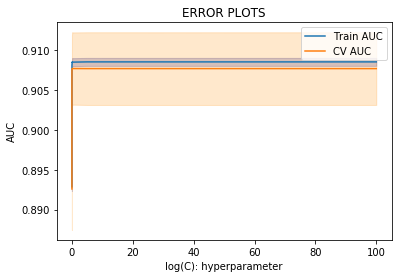

In [113]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [114]:
clf.best_estimator_

LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Testing with test data

In [115]:
log_reg=LogisticRegression(C=0.05,penalty='l2',class_weight='balanced')

log_reg.fit(sent_vectors_train,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(sent_vectors_test)[:,1])

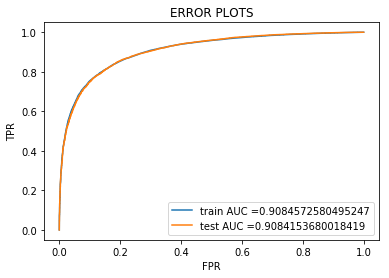

Train confusion matrix
[[ 8386  1501]
 [10748 46365]]
Test confusion matrix
[[ 4117   772]
 [ 5154 22957]]


In [116]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg.predict(sent_vectors_train)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg.predict(sent_vectors_test)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

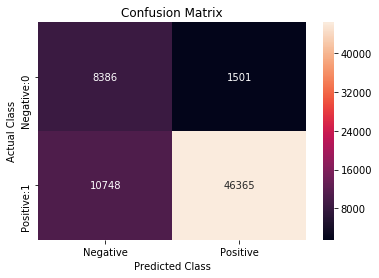

In [117]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_w2v = confusion_matrix(y_train, log_reg.predict(sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_w2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

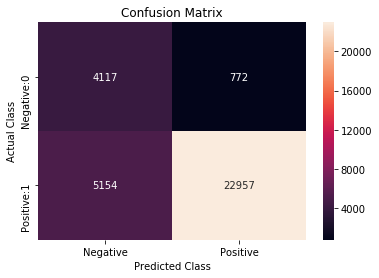

In [118]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_w2v = confusion_matrix(y_test, log_reg.predict(sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_w2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### Applying Logistic Regression with L1 regularization on AvgW2V

#### Applying gridsearch to do hyperparameter tuning

In [119]:
#Applying L1 regularizer on logistic regression AvgW2V

log_clf_w2v = LogisticRegression(n_jobs=-1,penalty='l1',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf_w2v, parameters, cv=10, scoring='roc_auc')
clf.fit(sent_vectors_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

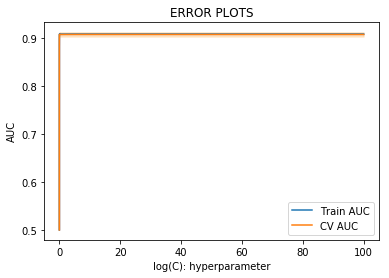

In [120]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [121]:
clf.best_estimator_

LogisticRegression(C=35, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Testing with test data

In [122]:
log_reg=LogisticRegression(C=35,penalty='l1',class_weight='balanced')

log_reg.fit(sent_vectors_train,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(sent_vectors_test)[:,1])

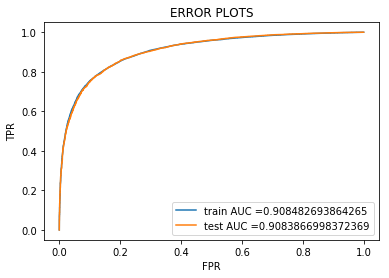

Train confusion matrix
[[ 8380  1507]
 [10707 46406]]
Test confusion matrix
[[ 4119   770]
 [ 5141 22970]]


In [123]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg.predict(sent_vectors_train)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg.predict(sent_vectors_test)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

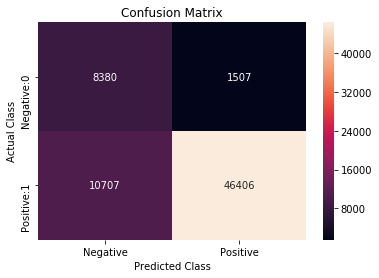

In [124]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_w2v = confusion_matrix(y_train, log_reg.predict(sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_w2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

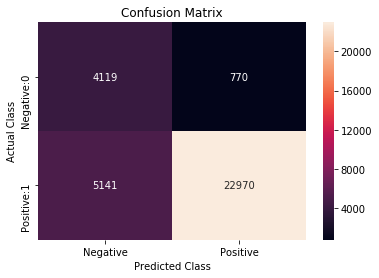

In [125]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_w2v = confusion_matrix(y_test, log_reg.predict(sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_w2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

## TFIDF weighted W2V

### Converting text into vectors using TFIDF Weighted W2V

In [127]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
tf_idf_matrix_test = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [128]:
#train data
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [129]:
#Training word2vec model on train data only
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))

[('terrific', 0.869182825088501), ('awesome', 0.8400696516036987), ('fantastic', 0.8352985978126526), ('good', 0.8340944051742554), ('wonderful', 0.8310648798942566), ('excellent', 0.828655481338501), ('perfect', 0.7735480666160583), ('incredible', 0.7416248321533203), ('amazing', 0.7413120269775391), ('nice', 0.7085621356964111)]
[('disgusting', 0.7362163066864014), ('greatest', 0.7311304211616516), ('best', 0.7279008626937866), ('nastiest', 0.7190055847167969), ('horrible', 0.6298810839653015), ('tastiest', 0.6233830451965332), ('awful', 0.6144516468048096), ('terrible', 0.5910933017730713), ('weirdest', 0.5719798803329468), ('encountered', 0.5674742460250854)]


In [130]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  15753
sample words  ['bought', 'pack', 'would', 'no', 'excuse', 'skip', 'breakfast', 'anymore', 'great', 'list', 'healthy', 'ingredients', 'calories', 'freezer', 'storage', 'recommended', 'preferred', 'means', 'pretty', 'much', 'always', 'fresh', 'stock', 'hand', 'toast', 'able', 'easy', 'grab', 'go', 'along', 'pluses', 'pros', 'filling', 'con', 'happens', 'taste', 'little', 'banana', 'flavor', 'mostly', 'sort', 'bland', 'vague', 'label', 'fiber', 'since', 'not', 'like', 'anything', 'baker']


#### Converting train data into vector form

In [131]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 67000/67000 [28:14<00:00, 39.53it/s]


#### Converting test data into vector

In [132]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [133]:
#test data

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [12:00<00:00, 45.65it/s]


### Applying Logistic Regression with L2 regularization on TFIDF Weighted W2V

#### Applying gridsearch to do hyperparameter tuning

In [134]:
#Applying L2 regularizer with logistic regression on TFIDF weighted W2V

log_clf_w2v = LogisticRegression(n_jobs=-1,penalty='l2',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf_w2v, parameters, cv=10, scoring='roc_auc')
clf.fit(tfidf_sent_vectors_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

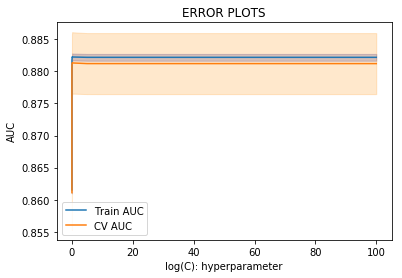

In [135]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [136]:
clf.best_estimator_

LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Testing with test data

In [137]:
#Testing with Test data

log_reg=LogisticRegression(C=0.05,penalty='l2',class_weight='balanced')

log_reg.fit(sent_vectors_train,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(tfidf_sent_vectors_test)[:,1])

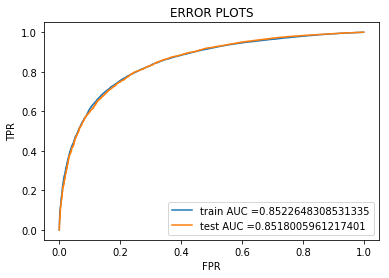

Train confusion matrix
[[ 7173  2714]
 [10527 46586]]
Test confusion matrix
[[ 3516  1373]
 [ 5110 23001]]


In [138]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg.predict(tfidf_sent_vectors_train)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg.predict(tfidf_sent_vectors_test)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

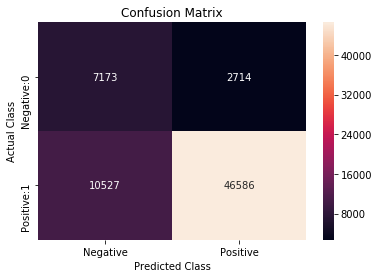

In [139]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_AvgTFIDF = confusion_matrix(y_train, log_reg.predict(tfidf_sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_AvgTFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

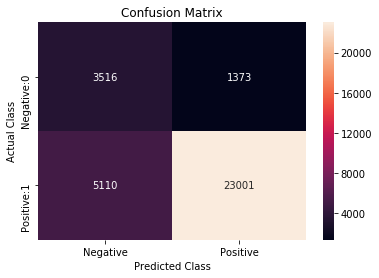

In [140]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_AvgTFIDF = confusion_matrix(y_test, log_reg.predict(tfidf_sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_AvgTFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### Applying Logistic Regression with L1 regularization on TFIDF Weighted W2V

#### Applying gridsearch to do hyperparameter tuning

In [141]:
#Applying logistic regression with L1 regularizer
log_clf_w2v = LogisticRegression(n_jobs=-1,penalty='l1',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf_w2v, parameters, cv=10, scoring='roc_auc')
clf.fit(tfidf_sent_vectors_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

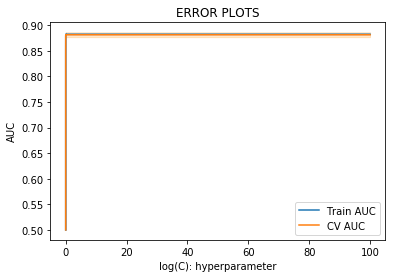

In [142]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [143]:
print("Best estimator is:",clf.best_estimator_)

Best estimator is: LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [144]:

log_reg=LogisticRegression(C=0.1,penalty='l1',class_weight='balanced')

log_reg.fit(tfidf_sent_vectors_train,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(tfidf_sent_vectors_test)[:,1])

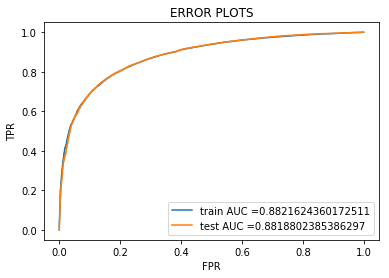

Train confusion matrix
[[ 8132  1755]
 [12182 44931]]
Test confusion matrix
[[ 4001   888]
 [ 5884 22227]]


In [145]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg.predict(tfidf_sent_vectors_train)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg.predict(tfidf_sent_vectors_test)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

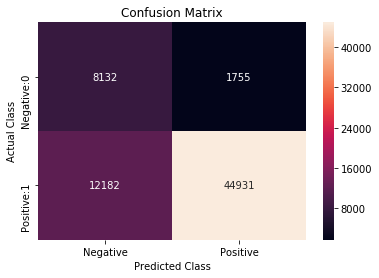

In [146]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_AvgTFIDF = confusion_matrix(y_train, log_reg.predict(tfidf_sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_AvgTFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

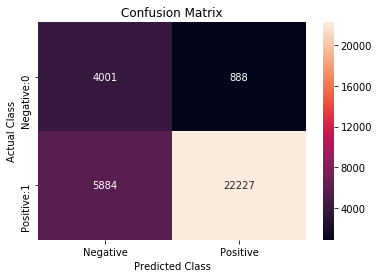

In [147]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_AvgTFIDF = confusion_matrix(y_test, log_reg.predict(tfidf_sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_train_AvgTFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### Feature Engineering

##### let do some feature engineerng on top of TFIDF and see if performance increased or not

In [148]:
#let do some feature engineerng on top of TFIDF and see if performance increased or not

#Taking length of reviews as another feature
#Added 2 columns extra :
#1st is total length of each preprocessed review 
#2nd is length of each preprocessed review by word

In [149]:
final["length of preprocessed_reviews"]=pd.Series(final["preprocessed_reviews"].str.len())
final["length of preprocessed_reviews_bywords"]=pd.Series(final["preprocessed_reviews"].str.split().str.len())

In [151]:
X=final.drop(["HelpfulnessDenominator","Score","Time","Summary"],axis=1)

In [152]:
X.head()

,Text,preprocessed_reviews,length of preprocessed_reviews,length of preprocessed_reviews_bywords
138702,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...,94,15
138707,"My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...,285,44
138708,This is one of the best children's books ever ...,one best children books ever written mini vers...,144,22
138692,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,title chicken soup riceauthor maurice sendakre...,403,57
138689,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,98,15


In [153]:
X=X.drop(["Text"],axis=1)
y=final["Score"]

In [154]:
X.head()

,preprocessed_reviews,length of preprocessed_reviews,length of preprocessed_reviews_bywords
138702,book purchased birthday gift year old boy sque...,94,15
138707,daughter loves really rosie books introduced r...,285,44
138708,one best children books ever written mini vers...,144,22
138692,title chicken soup riceauthor maurice sendakre...,403,57
138689,fun way children learn months year learn poems...,98,15


In [155]:
X_train_FT, X_test_FT, y_train_FT, y_test_FT = train_test_split(X[:100000], y[:100000], test_size=0.33,random_state=0) 

In [156]:
X_train_length_of_reviews_1=X_train_FT.drop("preprocessed_reviews",axis=1)

In [157]:
X_test_length_of_reviews_1=X_test_FT.drop("preprocessed_reviews",axis=1)

In [158]:
X_train_tf_idf_1=scipy.sparse.hstack((X_train_tf_idf,X_train_length_of_reviews_1)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [159]:
X_test_tf_idf_1=scipy.sparse.hstack((X_test_tf_idf,X_test_length_of_reviews_1)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [160]:
X_test_tf_idf_1.shape

(33000, 37868)

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(n_jobs=-1,penalty='l2',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf, parameters, cv=10, scoring='roc_auc')
clf.fit(X_train_tf_idf_1, y_train_FT)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

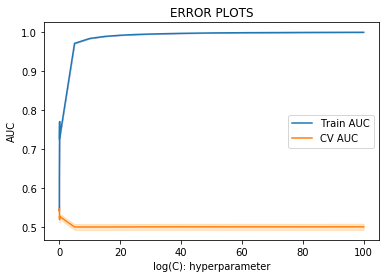

In [162]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [163]:
print("best estimator is:",clf.best_estimator_)

best estimator is: LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [165]:
log_reg=LogisticRegression(C=0.001,penalty='l2',class_weight='balanced')

log_reg.fit(X_train_tf_idf_1,y_train_FT)
train_fpr, train_tpr, thresholds = roc_curve(y_train_FT, log_reg.predict_proba(X_train_tf_idf_1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_FT, log_reg.predict_proba(X_test_tf_idf_1)[:,1])

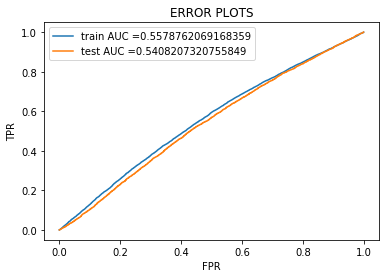

Train confusion matrix
[[ 4040  5899]
 [18140 38921]]
Test confusion matrix
[[ 1880  2957]
 [ 9119 19044]]


In [166]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train_FT, log_reg.predict(X_train_tf_idf_1)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test_FT, log_reg.predict(X_test_tf_idf_1)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

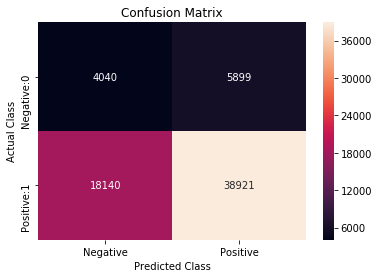

In [167]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_TFIDF = confusion_matrix(y_train_FT, log_reg.predict(X_train_tf_idf_1))

df_cm=pd.DataFrame(confusion_matrix_train_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

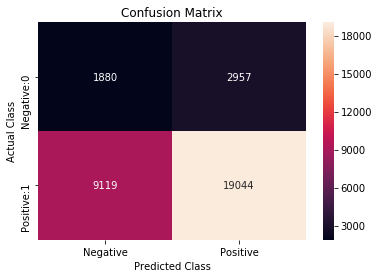

In [168]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_TFIDF = confusion_matrix(y_test_FT, log_reg.predict(X_test_tf_idf_1))

df_cm=pd.DataFrame(confusion_matrix_train_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

##### let do some feature engineerng on top of TFIDF-W2V and see if performance increased or not

In [169]:
#let do some feature engineerng on top of TFIDF-W2V and see if performance increased or not

#Taking length of reviews as another feature
#Added 2 columns extra :
#1st is total length of each preprocessed review 
#2nd is length of each preprocessed review by word

In [170]:
X_train_tf_idf_1=scipy.sparse.hstack((tfidf_sent_vectors_train,X_train_length_of_reviews_1)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [171]:
X_test_tf_idf_1=scipy.sparse.hstack((tfidf_sent_vectors_test,X_test_length_of_reviews_1)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [172]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(n_jobs=-1,penalty='l2',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf, parameters, cv=10, scoring='roc_auc')
clf.fit(X_train_tf_idf_1, y_train_FT)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

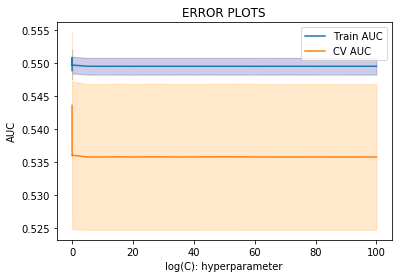

In [173]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [174]:
("best estimator is:",clf.best_estimator_)

('best estimator is:',
 LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False))

In [175]:
log_reg=LogisticRegression(C=0.0001,penalty='l2',class_weight='balanced')

log_reg.fit(X_train_tf_idf_1, y_train_FT)
train_fpr, train_tpr, thresholds = roc_curve(y_train_FT, log_reg.predict_proba(X_train_tf_idf_1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_FT, log_reg.predict_proba(X_test_tf_idf_1)[:,1])

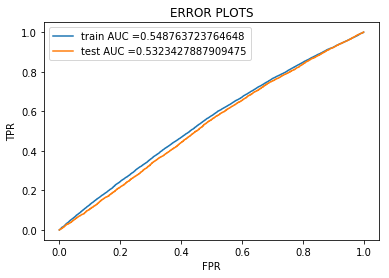

Train confusion matrix
[[ 4777  5162]
 [22932 34129]]
Test confusion matrix
[[ 2270  2567]
 [11541 16622]]


In [176]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train_FT, log_reg.predict(X_train_tf_idf_1)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test_FT, log_reg.predict(X_test_tf_idf_1)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

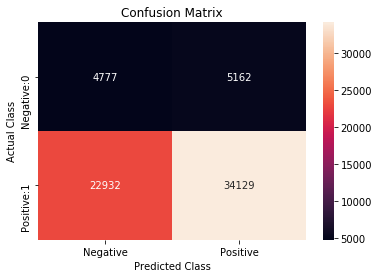

In [177]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_TFIDF = confusion_matrix(y_train_FT, log_reg.predict(X_train_tf_idf_1))

df_cm=pd.DataFrame(confusion_matrix_train_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

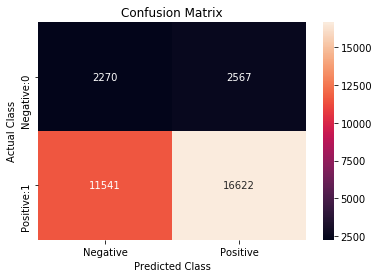

In [178]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_train_TFIDF = confusion_matrix(y_test_FT, log_reg.predict(X_test_tf_idf_1))

df_cm=pd.DataFrame(confusion_matrix_train_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

##### let do some feature engineerng on top of W2V and see if performance increased or not

In [179]:
#let do some feature engineerng on top of W2V and see if performance increased or not

#Taking length of reviews as another feature
#Added 2 columns extra :
#1st is total length of each preprocessed review 
#2nd is length of each preprocessed review by word

In [180]:
X_train_tf_idf_1=scipy.sparse.hstack((sent_vectors_train,X_train_length_of_reviews_1)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [181]:
X_test_tf_idf_1=scipy.sparse.hstack((sent_vectors_test,X_test_length_of_reviews_1)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(n_jobs=-1,penalty='l2',class_weight='balanced')
parameters = {'C':[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]}
clf = GridSearchCV(log_clf, parameters, cv=10, scoring='roc_auc')
clf.fit(X_train_tf_idf_1, y_train_FT)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.05, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

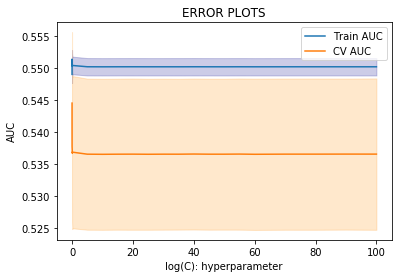

In [183]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C=[0.0001,0.001,0.01,0.1,0.05,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [184]:
print("best estimator is:",clf.best_estimator_)

best estimator is: LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [185]:
log_reg=LogisticRegression(C=0.0001,penalty='l2',class_weight='balanced')

log_reg.fit(X_train_tf_idf_1, y_train_FT)
train_fpr, train_tpr, thresholds = roc_curve(y_train_FT, log_reg.predict_proba(X_train_tf_idf_1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_FT, log_reg.predict_proba(X_test_tf_idf_1)[:,1])

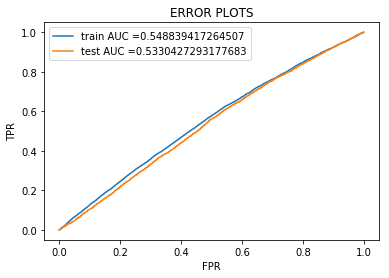

Train confusion matrix
[[ 4620  5319]
 [21970 35091]]
Test confusion matrix
[[ 2206  2631]
 [11040 17123]]


In [186]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train_FT, log_reg.predict(X_train_tf_idf_1)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test_FT, log_reg.predict(X_test_tf_idf_1)))

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

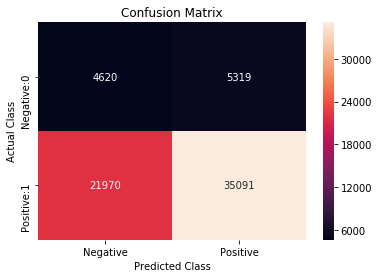

In [187]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_TFIDF = confusion_matrix(y_train_FT, log_reg.predict(X_train_tf_idf_1))

df_cm=pd.DataFrame(confusion_matrix_train_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

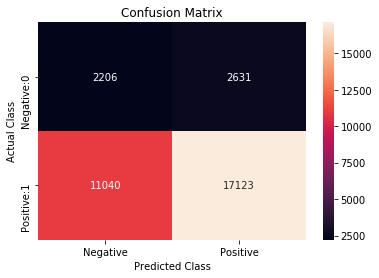

In [188]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_train_TFIDF = confusion_matrix(y_test_FT, log_reg.predict(X_test_tf_idf_1))

df_cm=pd.DataFrame(confusion_matrix_train_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [189]:
#all models are performing when we are adding length of each reviews as additional columns.

#hence feature engineering of adding length of each reviews is not useful in this case.

# Conclusion

In [190]:
from prettytable import PrettyTable
X=PrettyTable()
X.field_names=["Model_Name","Train_Accuracy","Test_Accuracy","Optimal_C"]
X.add_row(["Logistic Regression(L2 regularizer) With BOW", 91.2, 90.3, 0.05])
X.add_row(["Logistic Regression(L2 regularizer) With BOW", 91.1, 90.3, 0.1])
X.add_row(["Logistic Regression(L2 regularizer) With TFIDF", 99.6, 96.3, 5])
X.add_row(["Logistic Regression(L1 regularizer) With TFIDF", 99.8, 95.65,5])
X.add_row(["Logistic Regression(L2 regularizer) With AVG W2V", 90.84, 90.84,0.05])
X.add_row(["Logistic Regression(L1 regularizer) With AVG W2V", 90.8, 90.8,35])
X.add_row(["Logistic Regression(L2 regularizer) With TFIDF-AvgW2V", 85.2,85.1,0.05])
X.add_row(["Logistic Regression(L1 regularizer) With TFIDF-AvgW2V", 88.2,88.1,0.1])
print(X)

+-------------------------------------------------------+----------------+---------------+-----------+
|                       Model_Name                      | Train_Accuracy | Test_Accuracy | Optimal_C |
+-------------------------------------------------------+----------------+---------------+-----------+
|      Logistic Regression(L2 regularizer) With BOW     |      91.2      |      90.3     |    0.05   |
|      Logistic Regression(L2 regularizer) With BOW     |      91.1      |      90.3     |    0.1    |
|     Logistic Regression(L2 regularizer) With TFIDF    |      99.6      |      96.3     |     5     |
|     Logistic Regression(L1 regularizer) With TFIDF    |      99.8      |     95.65     |     5     |
|    Logistic Regression(L2 regularizer) With AVG W2V   |     90.84      |     90.84     |    0.05   |
|    Logistic Regression(L1 regularizer) With AVG W2V   |      90.8      |      90.8     |     35    |
| Logistic Regression(L2 regularizer) With TFIDF-AvgW2V |      85.2      

In [ ]:
#Logistic regression works well with L2 regularizer on TFIDF ,its giving 96.3% accuracy on test data

#however we tried to do some feature engineering by adding length of each reviews but models didnt perform well
#so we remove length of each reviews as newly added features from our model.